# 9-7. 프로젝트: 인물 모드 문제점 찾기
---

In [1]:
! pip3 install pixellib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 430 kB 18.7 MB/s 
     |████████████████████████████████| 151 kB 45.9 MB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 8.4 MB 52.3 MB/s 
     |████████████████████████████████| 1.5 MB 58.7 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
     |████████████████████████████████| 843 kB 55.5 MB/s 
     |████████████████████████████████| 117 kB 84.6 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 3.1 MB 51.7 MB/s 
     |████████████████████████████████| 97 kB 7.8 MB/s 
     |████████████████████████████████| 87 kB 8.4 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 344 k

In [1]:
! pip uninstall tensorflow

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2



In [2]:
! pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 463 kB 29.1 MB/s 
     |████████████████████████████████| 1.3 MB 57.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


Google colab 내부의 버전문제로 pixellib을 설치 / tensorflow를 다운그레이드했습니다.

---
## Step 0. Module import

먼저 필요한 모듈을 불러옵니다.

In [3]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import urllib # urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리
from pixellib.semantic import semantic_segmentation # pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

# Google Drive - Colab  연동을 위한 라이브러리 Import
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Exploration/data'

Mounted at /content/drive


다음으로 PixelLib에서 제공해 주는 모델을 다운로드하고 준비합니다.

In [4]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = data_dir+'/portrait/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/content/drive/MyDrive/Exploration/data/portrait/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f158c60cc10>)

---
## Step 1-1. 인물 사진 with blurred background

준비한 첫번째 이미지를 읽어오겠습니다.

첫번째 이미지는 배경을 블러처리 할 인물사진입니다.

(1440, 1440, 3)


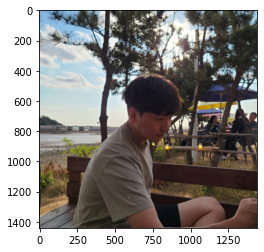

In [5]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = data_dir+'/portrait/me1.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

뒤에는 바다, 나무, 파라솔, 다른 사람들이 있습니다. 저를 제외한 다른 부분을 블러처리하고자 합니다.

다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성합니다.

In [6]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

이제 모델에 이미지를 입력해보겠습니다.

In [7]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용


segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 

PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

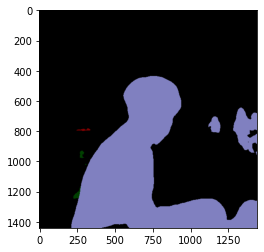

In [9]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [10]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  4, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
boat
person
pottedplant


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있고, segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있습니다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [12]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점입니다. colormap은 RGB 순서이고요.

그러니 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [14]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

이제 seg_color로만 이루어진 마스크를 만들어 보겠습니다.

(1440, 1440)


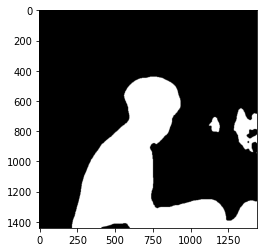

In [15]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같네요.

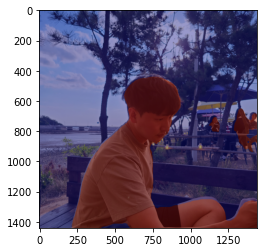

In [16]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

저는 이런 결과를 얻었어요.

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

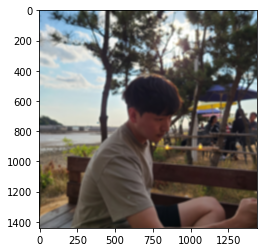

In [17]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (15,15))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

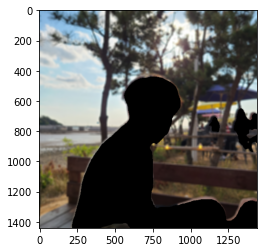

In [18]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

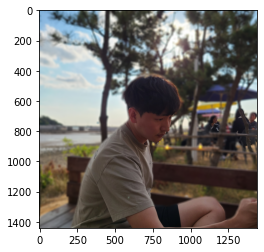

In [19]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

완성되었습니다..!만 뭔가 조금 이상하네요. 다른 이미지로도 진행해 보고 이부분에 대해서 프로젝트 마지막에 후술해보겠습니다.

---
## Step 1-2. 동물 사진 with blurred background

이번에는 위 과정과 똑같지만 사람이 아닌, 동물 사진을 이용하여 진행해보려합니다.

이미 동일한 과정이기 때문에, 주석과 설명은 생략하고 필요한 출력만 확인하며 진행할게요!

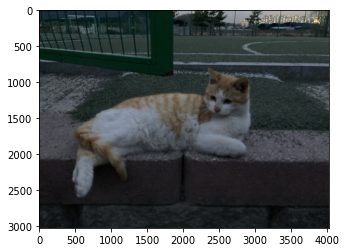

In [20]:
img_path = data_dir+'/portrait/cat1.png'  
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

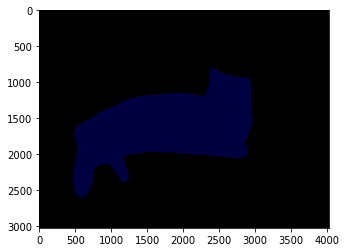

In [22]:
plt.imshow(output)
plt.show()

In [23]:
# 사진에 담겨있는 요소 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [24]:
 #컬러맵 8에 해당하는 배열 확인 (pacalvoc에 LABEL_NAMES 8번째인 고양이)
colormap[8]

array([64,  0,  0])

In [25]:
seg_color = (0,0,64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(3024, 4032)


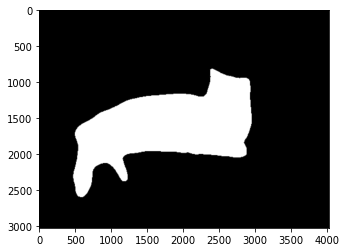

In [26]:
# 고양이 누끼
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

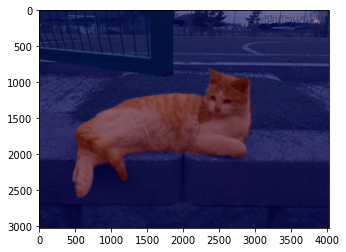

In [27]:
# 원본 이미지와 마스크를 적절히 섞어서 확인
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

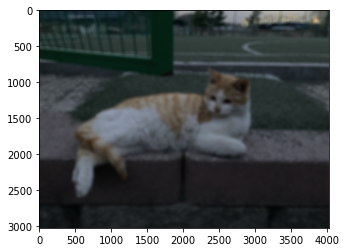

In [28]:
# 배경 블러처리
img_orig_blur = cv2.blur(img_orig, (50,50))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

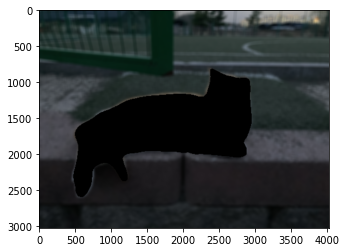

In [29]:
# 배경만 남은 이미지 얻기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

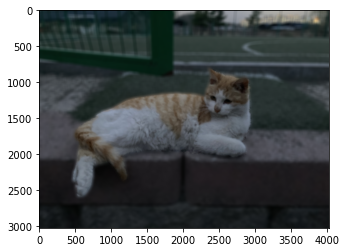

In [30]:
# 블러배경+고양이 합성(concat)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---
## Step 1-3. 크로마키 합성

위 과정을 적절히 응용하면, 블러처리된 배경이 아닌 다른 새로운 이미지도 배경으로 대체할 수 있지 않을까요?

바로 진행해보겠습니다. 마찬가지로 앞서 사용한 코드에 대한 내용은 간소화할게요!

(1080, 1080, 3)


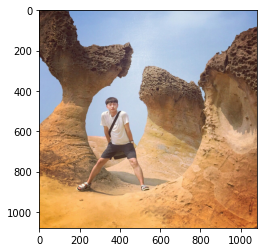

In [31]:
img_path = data_dir+'/portrait/me2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

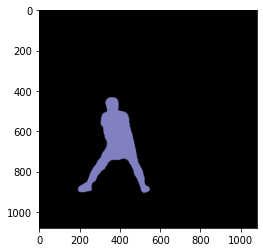

In [33]:
plt.imshow(output)
plt.show()

In [34]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [35]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [36]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(1080, 1080)


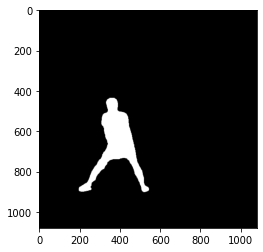

In [37]:
# 원본 이미지 중 사람 세그멘테이션만 얻기
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

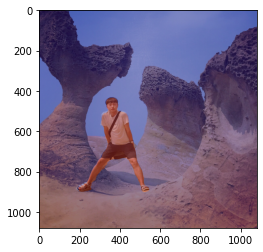

In [40]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 블러처리된 배경을 얻을 차례인데요, 이 부분에서 블러처리 된 배경 대신 새로운 배경을 얻어보겠습니다.

(1080, 1080, 3)


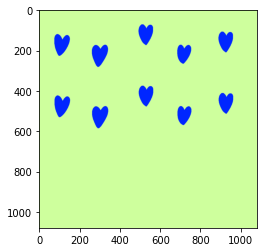

In [41]:
bg_img_path = data_dir+'/portrait/bg.png'  
bg_img_orig = cv2.imread(bg_img_path) 

print(bg_img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

배경으로 레트로한 스티커 이미지를 가져왔습니다!

아까 제가 서있던 부분을 제외한 배경 이미지만 얻도록 하겠습니다.

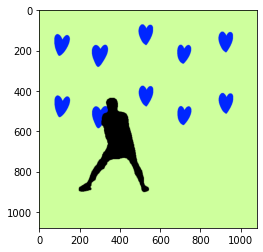

In [42]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
bg_img_orig = cv2.bitwise_and(bg_img_orig, img_bg_mask)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

이제 원본 사진과 배경을 합치면 되겠네요.

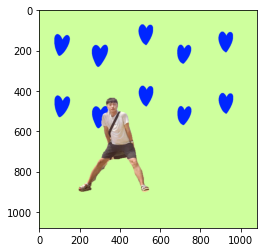

In [43]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, bg_img_orig)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

다소 허접하지만 어쨋거나 제 졸귀사진이 완성되었네요~

---
##Step 2. 문제점 찾기

앞서 [Step 1-1. 인물 사진 with blurred background]에서 인물과 블러처리된 배경을 합성한 인물사진을 얻을 수 있었습니다.

결과가 다소 어색했는데요, 어느 부분의 문제로 어색하게 느꼈는지 문제점을 인식해보고 이어서 해결 방안을 고민해보려합니다. 

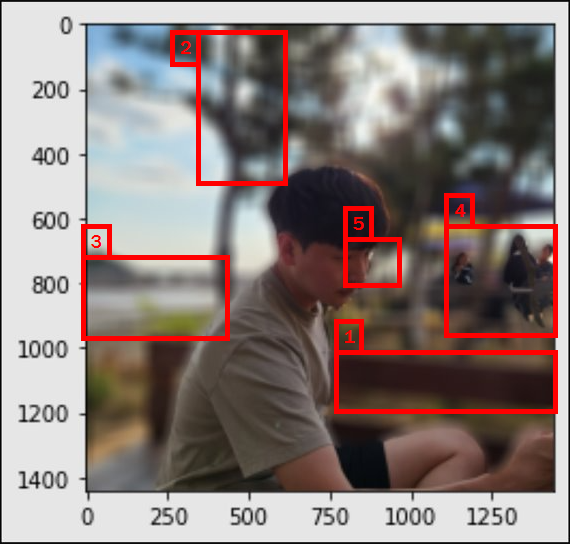

가장 큰 문제점으로 3가지를 들 수 있는데, 아래와 같습니다.

- 문제점 1
  - 1~3번 박스는 각각 바로 뒤의 난간, 그보다 먼 곳의 나무, 가장 먼 곳의 산과 바다이다.
  - 하지만 원근이 반영되지 않고 모두 같은 심도를 가지고 있기 때문에 제대로 된 shallow focus로 보이지 않는다.
- 문제점 2
  - 이미지에는 내가 아닌 다른 사람들도 있는데(4번 박스), 블러처리되지 않아서 어색한 결과가 만들어졌다.
- 문제점 3
  - 5번 박스를 보면 얼굴과 블러처리된 배경의 경계가 자연스럽지 않은 것을 볼 수 있다.
  - 이는 얼굴 뿐만이 아니라 '사람'으로 인식된 오브젝트 주변부에서 공통으로 관찰되는 문제점이다.

---
## Step 3. 해결 방법 제안

- 문제점 1의 경우  
  각각의 segmentation들은 각각 다른 원근을 가졌습니다. 구분하려면 어떻게 해야할까요?  
  저는 아래와 같은 방법을 생각해봤습니다.

      1. 어떤 A세그먼트가 다른 B세그먼트를 일부라도 가리게 된다면, A세그먼트에게 B세그먼트보다 높은 레벨을 부여한다.
      2. 마찬가지로 B세그먼트가 다른 C세그먼트를 일부라도 가리게 된다면, B세그먼트에게 C보다 높은 레벨을 부여한다.
      3. 이런 시퀀스를 반복하여 인접한 모든 세그먼트간에 각기 다른 계층(hierarchy)이 생성되게끔 한다.
      4. 이후 블러처리를 할 때 레벨이 낮은 segmentation일수록 높은 blurring curnel size를 주어 처리하도록 한다.

- 문제점 2의 경우  
  제가 아닌 다른 사람들을 블러처리 하려면 어떻게 해야할까요?  

      1. 똑같은 person으로 분류되더라도 person별로 다른 id를 가지도록 한다.
      2. 예를 들어)person 0, person 1, person2, ...
      3. 이후 마스킹을 진행 할 때, 원하는 person n.만 얻을 수 있도록 한다.

- 문제점 3의 경우  
  인물 세그먼트와 배경 사이의 불완전한 구분이 사진이 어색하게 보이게 하는 문제점이었는데요.  
  해결을 위한 step이 아닌 몇 가지 방법을 생각해봤습니다.  

      1. Segmentation을 좀더 tight하게 한다.
        이미지의 깊이가 급격하게 바뀌는 경계부를 검출 할 때, 임계값을 더 낮추어 segmentation한다.
        임계값을 낮추면 이미지 내의 경계부가 좀더 첨예하게 구분 되기 때문에, 결과 역시 같음은 자명하다.

      2. 마스킹단계에서부터 radius를 높여 경계부를 블러처리하여 마스킹 후 배경과 합성한다.
        마스킹 단계에서 이미 대상이 되는 세그먼트 주변부가 블러처리되어 있기 때문에, 대상 주변부와 위화감이 없을 것으로 예상된다.
        (포토샵의 이미지 합성과 같은 원리)  

      3. 세그먼트에서 가까울수록 블러값을 낮추고 멀수록 블러값을 높인다.
        이렇게 하면, 세그먼트 구분이 다소 첨예하게 되지 않더라도 자연스러운 블러처리된 이미지를 얻을 수 있을 것이다.
        물론 이때, 높아지는 블러값에는 적절한 한계값이 있어야 자연스러울 것이다.(이미지 주변부가 과하게 blurred되지 않도록)

---
## Fin.

- 일단 영상쪽 학습은 항상 재밌었고, 이번 Exploration 역시 그랬다. 주변에서 쉽게 접할 수 있는-상용화 되어있는- 기술들에 대해 이해도를 높일 수 있는 기회였고, 실제로 익숙한 것들이었기에 이해하고 학습하기에 큰 어려움이 없었다.

- 원본과 다른 배경 이미지를 합성 할 때, 크기가 다르면 어떨까 궁금했는데 역시나 이부분이 문제였다. resize를 통해 해결 할 수 있을 것 같았지만, 강제 resize는 분명히 이미지 왜곡을 만들 것이기에 외부 툴을 이용하여 알맞는 사이즈의 이미지로 패턴화함으로써 해결 할 수 있었다.

- 문제점과 그것에 대한 해결 과정을 기술하는 것이 상당히 힘들었다. 기존에 알고 있는 지식이더라도 그것을 간결하고 명확하게 표현하는 것은 다른 영역의 일이기에 굉장히 힘들었다. 앞으로 마주하는 다른 문제들에 대해서도 비슷하게 고민해보며 공학적인 사고방식을 키울 수 있도록 있도록 좀 더 연습해봐야겠다.